### A Start at some correspondence analysis like I did for Corpus Linguistics

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction import text
stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')

[Skip to load previously saved contingency table](#loadctab)

In [40]:
# Load the two data sets needed
# string encodings to try utf_8, iso8859_15
facetPlotData = pd.read_csv('facetPlotData.csv')
df = pd.read_csv('fullEmotionData.csv', encoding='utf_8') # apostrophes aren't being read correctly
# Pandas reads date as string, cast to datetime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
facetPlotData['date'] = pd.to_datetime(facetPlotData['date'], format='%Y-%m-%d')
facetPlotData.shape # Should be (3000, 4) 

(3000, 4)

<A HREF="https://regexr.com/">RegExr</A>

In [41]:
#Load SpaCy English Model
nlp = en_core_web_md.load()

In [42]:
punc = '''!()-[]{};:"\,<>./?—@#$%^&*_~â'''
sources = ['text_oba', 'text_nyt', 'text_wsj']
for source in sources:
    for i in range(len(df[source])):
        nopunc = ''.join([letter if letter not in punc else " " for letter in df[source][i] ])
        df.loc[i, source] =re.sub(' +', ' ', nopunc).replace('\n','').replace("' ", " ").strip()

In [18]:
# Tells pandas to print all the text when printing an article or speech not just a 50 character preview
pd.options.display.max_rows
pd.set_option('display.max_colwidth', None)

In [33]:
# Function to find date of max emoValue for a particular source and emotion
def findmax(sourcefm, emofm, printyn):
    '''
    Function to print date of maximum value of subset of data
    # sourcefm - source name (oba, nyt, wsj)
    # emofm - emotion name (fear,anger,trust,surprise,positive,negative,sadness,disgust,joy,anticipation)
    # printyn = 0 or 1 to print text
    '''
    find = facetPlotData[(facetPlotData['source'] == sourcefm) & (facetPlotData['emotion'] == emofm)]
    result = find.loc[find['emoValue'].idxmax()]
    date = result['date'].strftime('%Y-%m-%d')
    print(date, round(result['emoValue'], 4))
    if printyn == 1:
        text = 'text_' + sourcefm
        print(df.query('date == @date')[text])

In [44]:
findmax('oba', 'positive', 1)

2014-03-07 0.4107
65    good afternoon everybody before jay takes some...
Name: text_oba, dtype: object


### <A HREF="https://www.nltk.org/index.html">NLTK Documentation</A> <A HREF="https://www.tomaarsen.com/nltk/api/nltk.html">API reference</A>

In [47]:
# Run this if you want to remove stop words before creating contingency table
kaggle_file = open("./word_lists/kaggle_stopwords.txt", "r")
kaggle_data = kaggle_file.read()
kaggle_list = [word for word in kaggle_data.split('\n')]
kaggle_file.close()
my_list = ['thats', 'just', 'im', 'did', 'thing', 'mr', 'al', 'thank', 'okay', 'thank','thanks', 
           'question', 'joshua', 'president', 'obama', 's', 't', 'L', 'B', 'G', 'T', 'd', 've']
stop_list = list(set(kaggle_list) | set(my_list))
stop_words = text.ENGLISH_STOP_WORDS.union(stop_list)

' '.join([word for word in df['text_oba'][43].split() if word.lower() not in ENGLISH_STOP_WORDS])

"know tell I've said I've I've going evolution issue I've adamant gay lesbian Americans treated fairly equally that's addition we've administration rolling Don't Ask Don't Tell know outstanding Americans serve country it's longer defending Defense Marriage Act tried federalize historically state law I've stood broader equality L G B T community hesitated gay marriage thought civil unions sufficient people hospital visitation rights elements granted sensitive fact lot people know word marriage evokes powerful traditions religious beliefs forth tell course years talk friends family neighbors think members staff incredibly committed monogamous relationships sex relationships raising kids think soldiers airmen marines sailors fighting behalf feel constrained Don't Ask Don't Tell gone they're able commit marriage certain point I've just concluded personally important ahead affirm think sex couples able married tell hesitation didn't want nationalize issue There's tendency weigh think sudden

In [13]:
# Create a frequency list of all words in all Obama speeches

# How to flatten a list
#[item for sublist in list_of_lists for item in sublist]

freqlist = nltk.FreqDist([word.lower() for text in df['text_oba'] for word in text.split()])
freqlist

FreqDist({'the': 11954, 'and': 9652, 'to': 8764, 'of': 6814, 'that': 5389, 'a': 4920, 'in': 4358, 'we': 4186, 'our': 3594, 'for': 2635, ...})

In [63]:
sorted(dict(freqlist).items(),key=lambda x:x[1], reverse=True)[:20]

[('the', 11953),
 ('and', 9652),
 ('to', 8764),
 ('of', 6814),
 ('that', 5389),
 ('a', 4920),
 ('in', 4358),
 ('we', 4186),
 ('our', 3594),
 ('for', 2635),
 ('is', 2527),
 ('this', 2381),
 ('i', 2340),
 ('â', 1990),
 ('are', 1809),
 ('have', 1759),
 ('it', 1703),
 ('on', 1645),
 ('will', 1627),
 ('as', 1596)]

In [241]:
# list of all the words in the freqlist which is from all 100 documents
words = list(set(dict(freqlist).keys()))
# was getting a weird error below, just making sure all are strings, no numbers
words = [str(word) for word in words] 

### Create Contingency Table - counts of all words in all the documents

In [245]:
# Get counts of all words in 'words' for each speech/article
# I'm doing this the slow way so I can be sure the results are correct.
# I was getting weird numbers using other methods, 
#    like using sklearn countvectorizer I was getting 2900 for 'deepwater' when it should be 4
# I realize this is ugly
counts = []
for i in range(len(df['text_oba'])):
    sums = []
    for word in words:
        summ = 0
        for docword in df['text_oba'][i].split():
            if docword == word:
                summ+=1
        sums.append(summ)
    counts.append(sums)

In [246]:
# Oh man, this is so ugly, just brute force, no style or class. Oh well, it works!
totalcounts = []
for i in range(len(words)):
    summ = 0
    for j in range(len(counts)):
        summ += counts[j][i]
    totalcounts.append(summ)      

In [355]:
# total count of 'deepwater' should be 4 from one speech
word = 'deepwater'
[vectr[words.index(word)] for vectr in counts if vectr[words.index(word)]>0]

[4]

In [ ]:
# Contingency table
filenames = [name.replace('.txt', '') for name in df['file']]
conttab = pd.DataFrame(counts, columns = words, index = filenames, dtype='int')

In [254]:
conttab.loc['sum',:] = conttab.sum(axis=0)

In [255]:
conttab

,contemplating,be,encountered,laura,thomas,fine,deaths,mortgage,las,line,...,replace,bricks,singling,sort,launching,history,ran,heats,centralize,240
2008-06-04-ObamaNomination,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2008-11-05-ObamaElected,0.0,14.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2009-01-05-EconomyPlans,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-20-Inauguration,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0
2009-04-02-G20Speech,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-08-17-BatonRougeFloods,0.0,18.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-09-05-G20Summit,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-09-PresidentialElection,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2017-01-11-FarewellAddress,0.0,28.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0


In [357]:
# And here is the full Contingency Table, sorted with most frequent words first
conttab.sort_values(by='sum', axis=1, ascending=False, inplace=True)
conttab.drop('sum', inplace=True)
conttab

,the,and,to,of,that,a,in,we,our,for,...,evolved,hungered,students'that,doers,dared,supervision,sympathies,forthcoming,responsible1,outnumber
2008-06-04-ObamaNomination,258.0,248.0,184.0,150.0,130.0,112.0,100.0,78.0,86.0,88.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2008-11-05-ObamaElected,109.0,90.0,60.0,60.0,41.0,42.0,34.0,45.0,26.0,27.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05-EconomyPlans,57.0,35.0,48.0,22.0,34.0,18.0,17.0,23.0,8.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-20-Inauguration,141.0,113.0,72.0,86.0,50.0,47.0,25.0,62.0,68.0,23.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-04-02-G20Speech,70.0,58.0,56.0,32.0,29.0,24.0,29.0,33.0,23.0,7.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-07-28-DemocraticConvention,174.0,165.0,120.0,89.0,82.0,92.0,73.0,63.0,56.0,56.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-17-BatonRougeFloods,86.0,61.0,82.0,54.0,47.0,34.0,25.0,24.0,0.0,14.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2016-09-05-G20Summit,69.0,56.0,44.0,23.0,24.0,9.0,15.0,20.0,17.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-11-09-PresidentialElection,49.0,46.0,31.0,36.0,39.0,33.0,20.0,22.0,13.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [359]:
# Save table so we don't have to do this again
#conttab.to_csv('obamaContingencyTable.csv')

<a id='loadctab'>Load Contingency Table</a>

In [2]:
################################ LOAD CONTINGENCY TABLE ###############################
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable.csv',index_col=0)
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])

In [3]:
# Let's look at the 150 most common words
ctabshort=ctab.iloc[:, : 150]

<A HREF="https://github.com/MaxHalford/prince#correspondence-analysis-ca">Prince Correspondence Analysis</A>

In [4]:
ca = prince.CA(n_components=2,
               n_iter=3,copy=True,
               check_input=True,
               engine='auto',
               random_state=33)

In [5]:
ctabshort.columns.rename('words', inplace=True)
ctabshort.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort)

In [6]:
ca.row_coordinates(ctabshort).head()

,0,1
2008-06-04,-0.120510,0.042082
2008-11-05,-0.137581,-0.043255
2009-01-05,-0.091977,0.128107
2009-01-20,-0.136817,-0.252817
2009-04-02,-0.143712,-0.098502


In [7]:
ca.column_coordinates(ctabshort).head()

,0,1
the,-0.035112,-0.126647
and,-0.075835,-0.081246
to,-0.034337,0.017516
of,-0.036929,-0.138325
that,-0.076812,-0.016612


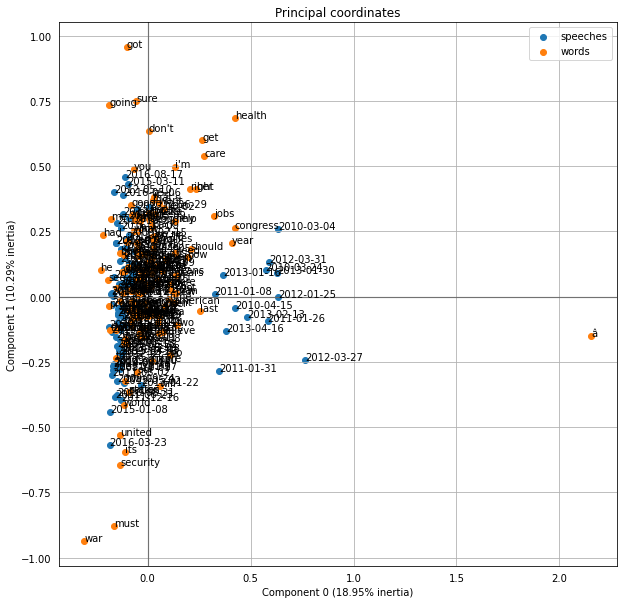

In [8]:
ax = ca.plot_coordinates(X=ctabshort,
                         ax=None,
                         figsize=(10, 10),
                         x_component=0,
                         y_component=1,
                         show_row_labels=True,
                         show_col_labels=True)

<A HREF="https://matplotlib.org/cheatsheets/cheatsheets.pdf">Matplotlib basic cheat sheet</A><BR>
    <A HREF="https://matplotlib.org/cheatsheets/">other matplotlib cheat sheets</A>

From NRC analysis the speech with particularly high anger value was 2015-01-08
and particularly high positive value on 2014-03-07

c:\users\peter\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


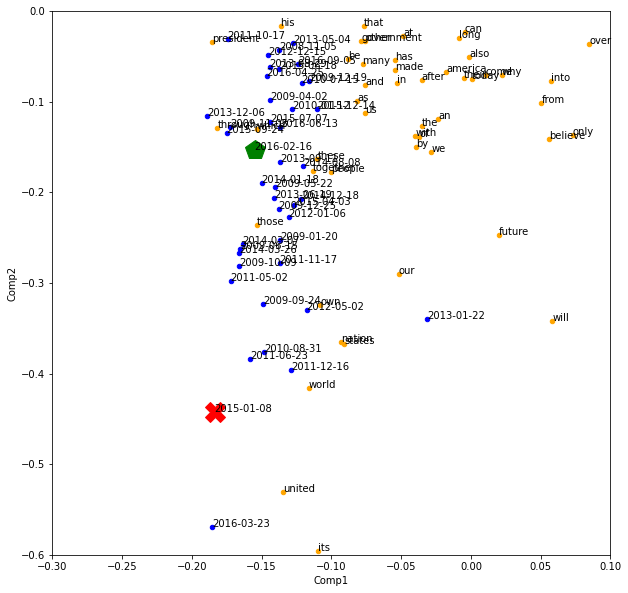

In [9]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-0.3, 0.1])
plt.ylim([-0.6, 0.0])
plt.show()

### Try correspondence analysis on a pre-selected list of words

In [11]:
# Load words from file
# topic words from topic modeling: "./word_lists/topic-words.txt"
# a custom list: "./word_lists/customlist.txt"
# common adjective: "./word_lists/adjectives.txt"
# common adverbs: "./word_lists/adverbs.txt"
# function words: "./word_lists/function-words.txt"
wordList = pd.read_csv("./word_lists/adjectives.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [12]:
# Make a short contingency list using topic words
ctabshort2 = ctab.loc[ : , [col for col in ctab.columns if col in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort2)[1] > 150:
    ctabshort2=ctabshort2.iloc[:, : 150]
    
ctabshort2.columns.rename('words', inplace=True)
ctabshort2.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort2)

c:\users\peter\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


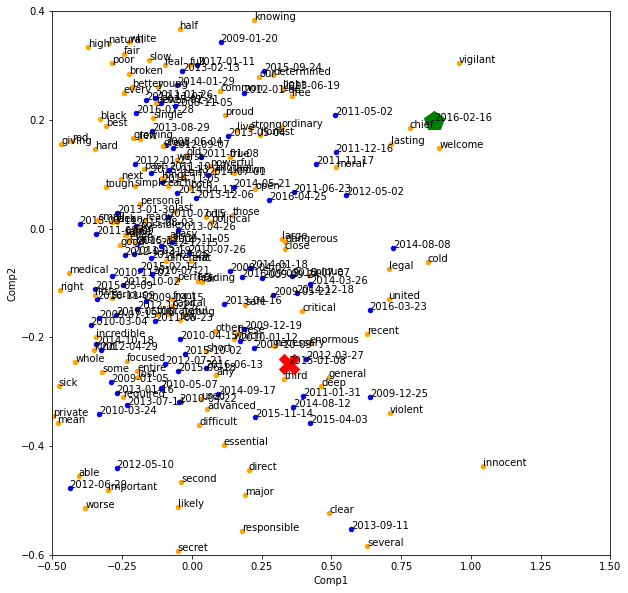

In [14]:
date1 = '2015-01-08'
date2 = '2016-02-16'
df1=ca.row_coordinates(ctabshort2)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort2)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-0.5, 1.5])
plt.ylim([-0.6, 0.4])
plt.show()

### Now try using the most frequent 150 words after removing the Kaggle 700 stop words

In [10]:
# Load words from file
# Kaggle stop words: "./word_lists/kaggle_stopwords.txt"
wordList = pd.read_csv("./word_lists/kaggle_stopwords.txt", sep=" ", header=None, 
                 names=["word"])
wordList = pd.DataFrame([word.lower() for word in list(wordList['word'])], columns=['word'])

In [11]:
number_of_words = 400
# Make a short contingency list removing the Kaggle stop words
ctabshort3 = ctab.loc[ : , [col for col in ctab.columns if col not in list(wordList['word'])]]

# Keep it to the most common 150 words
if np.shape(ctabshort3)[1] > number_of_words:
    ctabshort3=ctabshort3.iloc[:, : number_of_words]
    
ctabshort3.columns.rename('words', inplace=True)
ctabshort3.index.rename('speeches', inplace=True)
ca = ca.fit(ctabshort3)

c:\users\peter\appdata\local\programs\python\python39\lib\site-packages\pandas\plotting\_matplotlib\core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


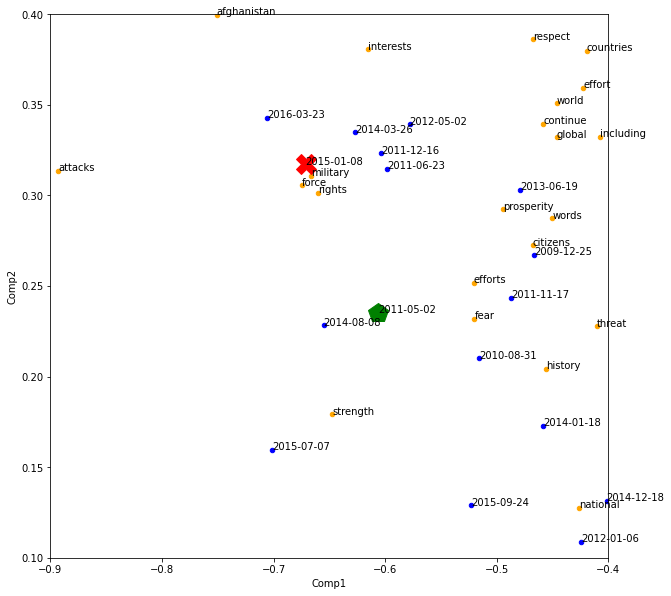

In [15]:
date1 = '2015-01-08' # date 1 is red X
date2 = '2011-05-02' # date 2 is green pentagon
df1=ca.row_coordinates(ctabshort3)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort3)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches - blue
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
for i, txt in enumerate(df1.index.values.tolist()):
    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words - orange
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)

plt.xlim([-0.9, -0.4])
plt.ylim([0.1, 0.4])
plt.show()